In [25]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [26]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            #eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            #eff_error.append((jsonFile['output_parameters']['efficiencyMuon_corrected']*(1-jsonFile['output_parameters']['efficiencyMuon_corrected'])/1000)**0.5)
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet
        
#print(HVCurrentDataFrame(5565))


In [27]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        #jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/output.json")
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        #jsonFile_fornTrig = json.load(jsonFile_fornTrig)
        nTrig = jsonFile['output_parameters']['nTrig']
        #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
        #print("N: ", N)
        #print("direc: ", direc)
        #print("current: ", hist_current_top.GetMean()+hist_current_bot.GetMean())
        #print("HV: ", hist_HV_top.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet
        
#print(HVCurrentDataFrame(5565))
        
#print(hist)
#canvas = ROOT.TCanvas("canvas")
#canvas.cd()
#canvas.SetLogy(True)
#hist.Draw("h")


In [28]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)

In [29]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }
Scans_30CO2 = {'30CO2_OFF': ['5819'],
         '30CO2_22':  ['5826'],
         '30CO2_10':  ['5832'], #HV7
         '30CO2_6.9': ['5830'], #HV7
         '30CO2_4.6': ['5831'],
         '30CO2_3.3': ['5822'],
         '30CO2_2.2': ['5827'], #HV7
         '30CO2_1': ['5820'] #HV7
         }
Scans_40CO2 = {'40CO2_OFF': ['5845'],
         '40CO2_22':  ['5846'],
         '40CO2_10':  ['5844'],
         '40CO2_6.9': ['5843'],
         '40CO2_4.6': ['5842'],
         '40CO2_3.3': ['5841'] # HV8
         }
Scans_STDMX = {'STDMX_OFF': ['5808'],
         'STDMX_22':  ['5813'],
         'STDMX_10':  ['5815'], #HV7
         'STDMX_6.9': ['5811'], #HV7 
         'STDMX_4.6': ['5807'],
         'STDMX_3.3': ['5814'],
         'STDMX_2.2': ['5805'], #HV7
         'STDMX_1': ['5810'], #HV7
         }
Scans_30CO205SF6 = {'30CO205SF6_OFF': ['5833'],
         '30CO205SF6_22':  ['5839'],
         '30CO205SF6_10':  ['5836'],
         '30CO205SF6_6.9': ['5837'],
         '30CO205SF6_4.6': ['5835'],
         '30CO205SF6_3.3': ['5834'],
         '30CO205SF6_2.2': ['5838'], #HV7
         '30CO205SF6_1': ['5840']} #HV7
scans_STDMX = [
         ['STDMX_OFF', sigmoid1, 6, 23],
         ['STDMX_22', sigmoid2, 3, 22],
         ['STDMX_4.6', sigmoid3, 1, 34],
         ['STDMX_3.3', sigmoid4, 2, 20],
         ['STDMX_1', sigmoid5, 4, 21],
         ]
scans_30CO2 = [
         ['30CO2_OFF', sigmoid6, 6, 23],
         ['30CO2_22', sigmoid7, 3, 22],
         ['30CO2_4.6', sigmoid8, 1, 34],
         ['30CO2_3.3', sigmoid9, 2, 20],
         ['30CO2_1', sigmoid10, 4, 21],
         ]
scans_30CO205SF6 = [
         ['30CO205SF6_OFF', sigmoid16, 6, 23],
         ['30CO205SF6_10', sigmoid17, 3, 22],
         ['30CO205SF6_4.6', sigmoid18, 1, 34],
         ['30CO205SF6_2.2', sigmoid19, 2, 20],
         ['30CO205SF6_1', sigmoid20, 4, 21],
         ]
scans_40CO2 = [
         ['40CO2_OFF', sigmoid11, 6, 23],
         ['40CO2_22', sigmoid12, 3, 22],
         ['40CO2_10', sigmoid13, 1, 34],
         ['40CO2_4.6', sigmoid14, 2, 20],
         ['40CO2_3.3', sigmoid15, 4, 21],
         ]

In [30]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 
    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  

In [31]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))

scanID:  5845
scanID:  5846
scanID:  5844
scanID:  5843
scanID:  5842
scanID:  5841
scanID:  5845
scanID:  5846
scanID:  5844
scanID:  5843
scanID:  5842
scanID:  5841
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.908333     0.675833  7000.0  7000.0     0.023776      0.000225   
1     9.063140     7.805416  7000.0  7000.0     0.024847      0.011061   
2    17.024096    15.139259  7000.0  7000.0     0.025918      0.020561   
3    24.642144    21.794923  7000.0  7000.0     0.023045      0.028155   
4    32.087562    28.356041  7000.0  7000.0     0.023824      0.034470   
5    47.500257    42.183781  7000.0  7000.0     0.023215      0.048381   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.048760  1.361280  2.379098  1.416013     0.162951      0.035061   
1  1.070776  1.867909  2.308344  1.979245     0.156086      0.150436   
2  1.095825  2.926823  2.257322  1.950481     0.149849      0.2

In [32]:
for scan_name, scan_ids in scans.items():
    dataFrame = HVCurrentDataFrame(scan_ids)
    dataFrame.to_csv(f'Data_2023/{scan_name}.csv', index=False)
    print(f"Arquivo CSV criado: {scan_name}!")

Arquivo CSV criado: 30CO2_OFF!
Arquivo CSV criado: 30CO2_22!
Arquivo CSV criado: 30CO2_10!
Arquivo CSV criado: 30CO2_6.9!
Arquivo CSV criado: 30CO2_4.6!
Arquivo CSV criado: 30CO2_3.3!
Arquivo CSV criado: 30CO2_2.2!
Arquivo CSV criado: 30CO2_1!
Arquivo CSV criado: 30CO205SF6_OFF!
Arquivo CSV criado: 30CO205SF6_22!
Arquivo CSV criado: 30CO205SF6_10!
Arquivo CSV criado: 30CO205SF6_6.9!
Arquivo CSV criado: 30CO205SF6_4.6!
Arquivo CSV criado: 30CO205SF6_3.3!
Arquivo CSV criado: 30CO205SF6_2.2!
Arquivo CSV criado: 30CO205SF6_1!
Arquivo CSV criado: 40CO2_OFF!
Arquivo CSV criado: 40CO2_22!
Arquivo CSV criado: 40CO2_10!
Arquivo CSV criado: 40CO2_6.9!
Arquivo CSV criado: 40CO2_4.6!
Arquivo CSV criado: 40CO2_3.3!
Arquivo CSV criado: STDMX_OFF!
Arquivo CSV criado: STDMX_22!
Arquivo CSV criado: STDMX_10!
Arquivo CSV criado: STDMX_6.9!
scanId =  5630
Arquivo CSV criado: STDMX_4.6!
Arquivo CSV criado: STDMX_3.3!
Arquivo CSV criado: STDMX_2.2!
Arquivo CSV criado: STDMX_1!


In [33]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))

scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.729052     0.573356  6950.0  6950.0     0.023953      0.000650   
1     9.885142     8.778891  7060.0  7060.0     0.035293      0.017356   
2    17.803002    15.848965  7060.0  7060.0     0.028751      0.031319   
3    25.854911    22.977375  7060.0  7060.0     0.030122      0.042524   
4    33.528084    30.002467  7060.0  7060.0     0.029922      0.054032   
5    50.053757    44.876121  7060.0  7060.0     0.023695      0.072797   
6   110.092891    98.324803  7000.0  7000.0     0.015029      0.098907   
7    58.901701    52.498809  7000.0  7000.0     0.019968      0.073303   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err 

In [34]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))

scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.516166     0.416491  7060.0  7060.0     0.018003      0.000250   
1     8.236441     7.194407  7100.0  7100.0     0.019441      0.008320   
2    14.676590    12.431754  7060.0  7060.0     0.018289      0.012954   
3    22.606310    19.578012  7100.0  7100.0     0.017575      0.023247   
4    27.569545    23.575042  7060.0  7060.0     0.015797      0.023081   
5    42.202164    36.301476  7060.0  7060.0     0.016382      0.034044   
6    86.810166    75.809578  7100.0  7100.0     0.013570      0.058803   
7   106.863310    93.091297  7100.0  7100.0     0.011497      0.066622   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

In [35]:
Features_STDMX = FeaturesDataFrame(Scans_STDMX)
Features_STDMX['gamma_CM'][0] = 1
Features_STDMX['gamma_CS'][0] = 1
Features_STDMX['noiseGammaRate'][0] = 1
print("Features_STDMX = ", Features_STDMX)

scanID:  5808
scanID:  5813
scanID:  5815


scanID:  5811
scanID:  5807
scanID:  5814
scanID:  5805
scanID:  5810
Features_STDMX =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.662577     0.579678  7250.0  7250.0     0.021638      0.000510   
1     7.331106     6.235990  7250.0  7250.0     0.020339      0.009124   
2    12.528288    10.652905  7200.0  7200.0     0.013554      0.013070   
3    18.163424    15.603424  7200.0  7200.0     0.018294      0.017172   
4    25.579945    21.916266  7250.0  7250.0     0.020301      0.028520   
5    38.579806    33.307197  7250.0  7250.0     0.016467      0.040073   
6    45.416834    38.666666  7200.0  7200.0     0.012144      0.035533   
7    86.239032    73.963387  7200.0  7200.0     0.008774      0.050569   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.056347   1.000000  2.149189  1.000000     0.128334      0.049051   
1  1.077327   1.858821  2.120928  1.854984     0.120509      0.141672   
2  1.087038   2.808565  1.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file current.png has been created


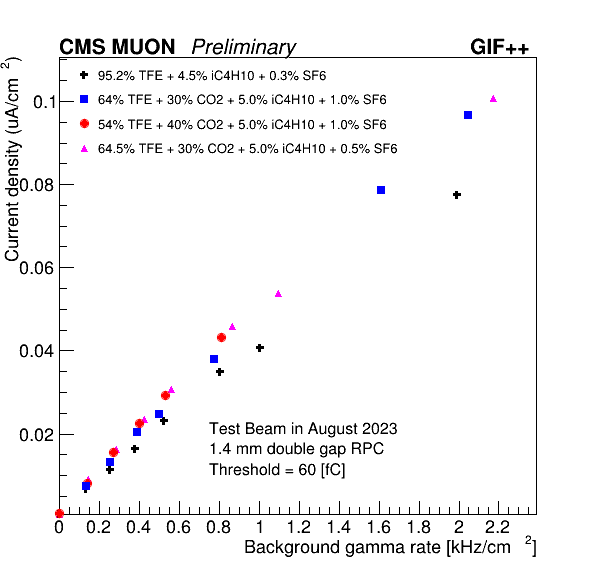

In [36]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
        
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   Features_40CO2['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   Features_30CO2['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)

_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   Features_30CO205SF6['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   Features_STDMX['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Hit background gamma rate [kHz/cm2]")
_30CO205SF6.GetYaxis().SetTitle("Current (uA)")
_30CO205SF6.GetYaxis().SetTitleOffset(1.2)
_30CO205SF6.Draw("AP")
_40CO2.Draw("PSAME")
_30CO2.Draw("PSAME")
STDMX.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.12, 0.72, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(0.8, 27, "Test Beam in April+July 2023");
ltx_data.DrawLatex(0.8, 23, "1.4 mm double gap RPC");
ltx_data.DrawLatex(0.8, 19, "Threshold = 60 [fC]")
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("current.png")


In [37]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
        
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   Features_40CO2['current'].values/2070.5,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   Features_30CO2['current'].values/2070.5,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)

_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   Features_30CO205SF6['current'].values/2070.5,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   Features_STDMX['current'].values/2070.5,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Background gamma rate [kHz/cm^{2}]")
_30CO205SF6.GetYaxis().SetTitle("Current density (uA/cm^{2})")
_30CO205SF6.GetYaxis().SetTitleOffset(1.45)
_30CO205SF6.GetYaxis().SetMaxDigits(3)
_30CO205SF6.Draw("AP")
STDMX.Draw("PSAME")
_40CO2.Draw("PSAME")
_30CO2.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.1, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.12, 0.72, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(0.75, 0.02, "Test Beam in August 2023");
ltx_data.DrawLatex(0.75, 0.015, "1.4 mm double gap RPC");
ltx_data.DrawLatex(0.75, 0.01, "Threshold = 60 [fC]");
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("density_current.png")
canvas.SaveAs("density_current.pdf")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file density_current.png has been created
Info in <TCanvas::Print>: pdf file density_current.pdf has been created


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file charge.png has been created


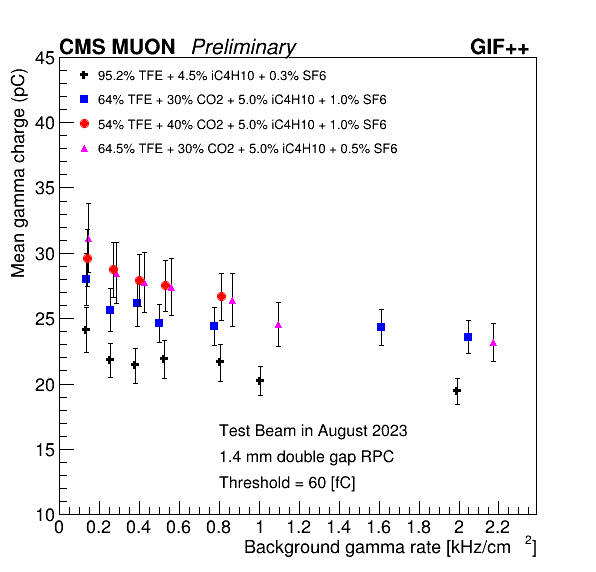

In [38]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
    
_40CO2_charge = 1000000*Features_40CO2['current'].values/(2*2070.5*Features_40CO2['noiseGammaRate'].values/Features_40CO2['gamma_CS'].values)
_40CO2_charge[0] = 0
_40CO2_charge_err = (1000000*Features_40CO2['current'].values/(2*2070.5))*(Features_40CO2['gamma_CS_err'].values/Features_40CO2['noiseGammaRate'].values) 
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   _40CO2_charge,
                   0,
                   _40CO2_charge_err) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2_charge = 1000000*Features_30CO2['current'].values/(2*2070.5*Features_30CO2['noiseGammaRate'].values/Features_30CO2['gamma_CS'].values)
_30CO2_charge[0] = 0
_30CO2_charge_err = (1000000*Features_30CO2['current'].values/(2*2070.5))*(Features_30CO2['gamma_CS_err'].values/Features_30CO2['noiseGammaRate'].values) 

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   _30CO2_charge,
                   0,
                   _30CO2_charge_err) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)

_30CO205SF6_charge = 1000000*Features_30CO205SF6['current'].values/(2*2070.5*Features_30CO205SF6['noiseGammaRate'].values/Features_30CO205SF6['gamma_CS'].values)
_30CO205SF6_charge[0] = 0
_30CO205SF6_charge_err = (1000000*Features_30CO205SF6['current'].values/(2*2070.5))*(Features_30CO205SF6['gamma_CS_err'].values/Features_30CO205SF6['noiseGammaRate'].values) 

_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   _30CO205SF6_charge,
                   0,
                   _30CO205SF6_charge_err) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX_charge = 1000000*Features_STDMX['current'].values/(2*2070.5*Features_STDMX['noiseGammaRate'].values/Features_STDMX['gamma_CS'].values)
STDMX_charge[0] = 0
STDMX_charge_err = (1000000*Features_STDMX['current'].values/(2*2070.5))*(Features_STDMX['gamma_CS_err'].values/Features_STDMX['noiseGammaRate'].values) 

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   STDMX_charge,
                   0,
                   STDMX_charge_err) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Background gamma rate [kHz/cm^{2}]")
_30CO205SF6.GetYaxis().SetTitle("Mean gamma charge (pC)")
_30CO205SF6.GetYaxis().SetTitleOffset(1.2)
_30CO205SF6.GetYaxis().SetRangeUser(10., 45.)
_30CO205SF6.GetYaxis().SetMaxDigits(3)
_30CO205SF6.Draw("AP")
_30CO2.Draw("PSAME")
_40CO2.Draw("PSAME")
STDMX.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.12, 0.72, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(0.8, 16., "Test Beam in August 2023");
ltx_data.DrawLatex(0.8, 14., "1.4 mm double gap RPC");
ltx_data.DrawLatex(0.8, 12., "Threshold = 60 [fC]");
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("charge.png")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file RXI.png has been created


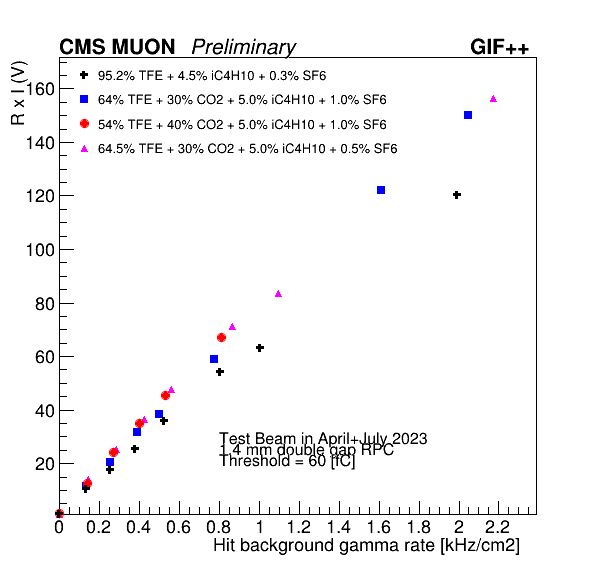

In [39]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
        
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   0.75*Features_40CO2['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   0.75*Features_30CO2['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)

_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   0.75*Features_30CO205SF6['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   0.75*Features_STDMX['current'].values,
                   0,
                   0) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Hit background gamma rate [kHz/cm2]")
_30CO205SF6.GetYaxis().SetTitle("R x I (V)")
_30CO205SF6.GetYaxis().SetTitleOffset(1.2)
_30CO205SF6.Draw("AP")
_30CO2.Draw("PSAME")
_40CO2.Draw("PSAME")
STDMX.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.12, 0.72, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(0.8, 27, "Test Beam in April+July 2023");
ltx_data.DrawLatex(0.8, 23, "1.4 mm double gap RPC");
ltx_data.DrawLatex(0.8, 19, "Threshold = 60 [fC]");
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("RXI.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file MuonCM.png has been created


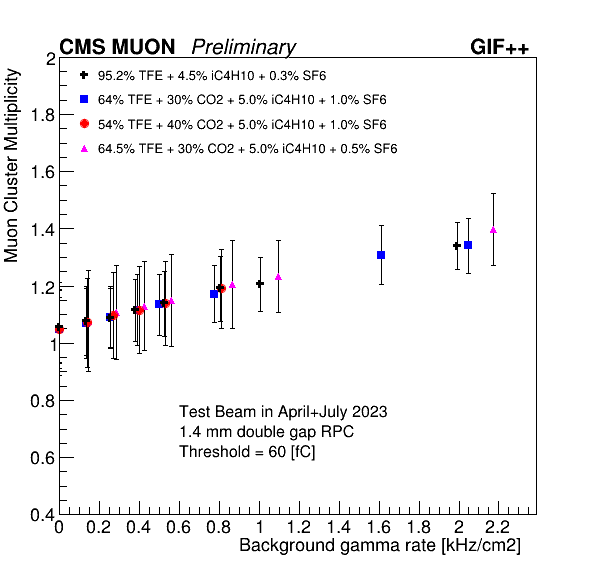

In [40]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
        
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   Features_40CO2['muon_CM'].values,
                   0,
                   Features_40CO2['muon_CM_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   Features_30CO2['muon_CM'].values,
                   0,
                   Features_30CO2['muon_CM_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)

_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   Features_30CO205SF6['muon_CM'].values,
                   0,
                   Features_30CO205SF6['muon_CM_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   Features_STDMX['muon_CM'].values,
                   0,
                   Features_STDMX['muon_CM_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Background gamma rate [kHz/cm2]")
_30CO205SF6.GetYaxis().SetTitle("Muon Cluster Multiplicity")
_30CO205SF6.GetYaxis().SetTitleOffset(1.4)
_30CO205SF6.GetYaxis().SetRangeUser(0.4, 2.)
_30CO205SF6.Draw("AP")
_30CO2.Draw("PSAME")
_40CO2.Draw("PSAME")
STDMX.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.12, 0.72, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX,  "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(0.6, 0.74, "Test Beam in April+July 2023");
ltx_data.DrawLatex(0.6, 0.67, "1.4 mm double gap RPC");
ltx_data.DrawLatex(0.6, 0.6, "Threshold = 60 [fC]");
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("MuonCM.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file MuonCS.png has been created


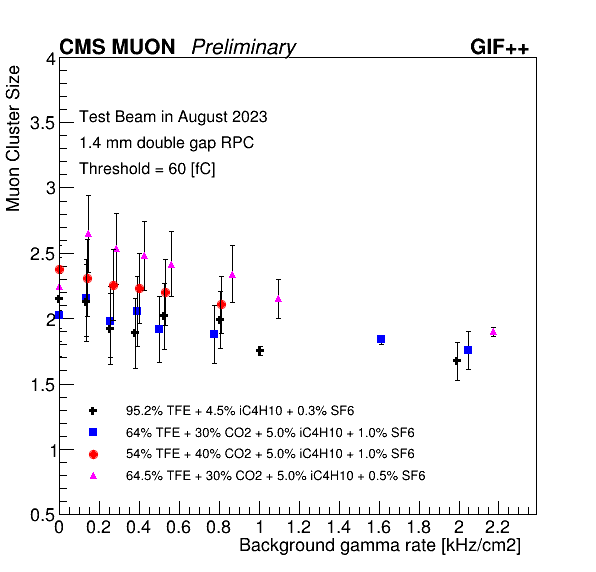

In [41]:
canvas = TCanvas("c", "c", 564, 232, 600, 600)
    
_40CO2 = TGraphErrors(6, 
                   Features_40CO2['noiseGammaRate'].values/(Features_40CO2['gamma_CS'].values*1000), 
                   Features_40CO2['muon_CS'].values,
                   0,
                   Features_40CO2['muon_CS_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_40CO2.SetMarkerColor(2)
_40CO2.SetMarkerStyle(20)

_30CO2 = TGraphErrors(8, 
                   Features_30CO2['noiseGammaRate'].values/(Features_30CO2['gamma_CS'].values*1000), 
                   Features_30CO2['muon_CS'].values,
                   0,
                   Features_40CO2['muon_CS_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO2.SetMarkerColor(4)
_30CO2.SetMarkerStyle(21)


_30CO205SF6 = TGraphErrors(8, 
                   Features_30CO205SF6['noiseGammaRate'].values/(Features_30CO205SF6['gamma_CS'].values*1000), 
                   Features_30CO205SF6['muon_CS'].values,
                   0,
                   Features_40CO2['muon_CS_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
_30CO205SF6.SetMarkerColor(6)
_30CO205SF6.SetMarkerStyle(22)

STDMX = TGraphErrors(8, 
                   Features_STDMX['noiseGammaRate'].values/(Features_STDMX['gamma_CS'].values*1000), 
                   Features_STDMX['muon_CS'].values,
                   0,
                   Features_40CO2['muon_CS_err'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
STDMX.SetMarkerColor(1)
STDMX.SetMarkerStyle(34)

_30CO205SF6.SetTitle("")
_30CO205SF6.GetXaxis().SetTitle("Background gamma rate [kHz/cm2]")
_30CO205SF6.GetYaxis().SetTitle("Muon Cluster Size")
_30CO205SF6.GetYaxis().SetRangeUser(.5, 4.)
_30CO205SF6.GetYaxis().SetTitleOffset(1.4)
_30CO205SF6.Draw("AP")
_30CO2.Draw("PSAME")
_40CO2.Draw("PSAME")
STDMX.Draw("PSAME")

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.1, 0.15, 0.55, 0.3);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.025); 
legend.AddEntry(STDMX, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6", "P");
legend.AddEntry(_30CO2, "64% TFE + 30% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_40CO2, "54% TFE + 40% CO2 + 5.0% iC4H10 + 1.0% SF6", "P");
legend.AddEntry(_30CO205SF6, "64.5% TFE + 30% CO2 + 5.0% iC4H10 + 0.5% SF6", "P");
legend.Draw();

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.03);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(.1, 3.5, "Test Beam in August 2023");
ltx_data.DrawLatex(.1, 3.3, "1.4 mm double gap RPC");
ltx_data.DrawLatex(.1, 3.1, "Threshold = 60 [fC]");
ltx_data.Draw()

canvas.Draw()
canvas.SaveAs("MuonCS.png")


In [42]:

TGraphs_list_STDMX = []
func_list_STDMX = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref= 95

k=1

for scan, sigmoid, color, marker in scans_STDMX:
    n = len(HVCurrentDataFrame(scans[scan])['HV_top'])
        
    gr_E = TGraphErrors(n, 
                    #HVCurrentDataFrame(scans[scan])['HV_top'].values - HVCurrentDataFrame(scans[scan])['deltaV'].values, 
                    HVCurrentDataFrame(scans[scan])['HV_top'].values, 
                    HVCurrentDataFrame(scans[scan])['efficiency'].values,
                    #HVCurrentDataFrame(scans[scan])['deltaV_err'].values,
                    0,
                    HVCurrentDataFrame(scans[scan])['eff_error'].values) #values from df[].values to convert dataframe object in array suitable for the tgraph
    gr_E.Fit(sigmoid) # FIT the graph with the sigmoid
    sigmoid.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    #estrazione valori da fit
    sig= gr_E.GetFunction("sigmoid"+str(k))
    sig.SetLineColor(color)

    Emax=sig.GetParameter(0)
    Emax_err=sig.GetParError(0)     

    Lambda=sig.GetParameter(1)    
    Lambda_err=sig.GetParError(1)      

    HV50=sig.GetParameter(2)
    HV50_err=sig.GetParError(2)      
    print("Lambda = ", Lambda)
    HV95=sig.GetX(HV_ref)
    HV95_err= math.sqrt(((math.log(19)/Lambda**2)*Lambda_err)**2 + HV50_err**2) #errore HV95
    print("HV95_err = ", HV95_err)

    #check print efficiency curves fitted
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k=k+1
    #canvas.Draw()
    canvas.SaveAs(scan+".png")

Lambda =  0.01216180708246331
HV95_err =  3.7603528229451637
Lambda =  0.010335318171727925
HV95_err =  3.278368380127679
scanId =  5630
scanId =  5630
scanId =  5630
scanId =  5630
Lambda =  0.010336983687918154
HV95_err =  3.46417866996463
Lambda =  0.01056025004644915
HV95_err =  3.4716011042430694
Lambda =  0.011974763187287744
HV95_err =  4.129418620077054
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      14.1711
NDf                       =            7
Edm                       =  1.14577e-05
NCalls                    =           90
Emax                      =     0.989618   +/-   0.000818564 
Lambda                    =    0.0121618   +/-   0.000163772 
HV50                      =      6787.79   +/-   1.87384     
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      72.1319
NDf                       =           14
Edm                       =    2.731e-07
NCalls               

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <TCanvas::Print>: png file STDMX_OFF.png has been created
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <TCanvas::Print>: png file STDMX_22.png has been created
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xm

In [43]:

canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
TGraphs_list_STDMX[0].SetTitle("")
TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
TGraphs_list_STDMX[0].GetYaxis().SetTitle("Muon Efficiency")
TGraphs_list_STDMX[0].Draw("AP")
TGraphs_list_STDMX[1].Draw("PSAME")
TGraphs_list_STDMX[2].Draw("PSAME")
TGraphs_list_STDMX[3].Draw("PSAME")
TGraphs_list_STDMX[4].Draw("PSAME")

Emax_STDMX = []
Emax_err_STDMX = []
Lambda_STDMX = []
Lambda_err_STDMX = []
HV50_STDMX = []
HV50_err_STDMX = []
HV95_STDMX = []
HV95_err_STDMX = []

for sig in func_list_STDMX:
    Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
    Emax_STDMX.append(Emax_)
    Emax_err_STDMX.append(sig.GetParError(0))     
    Lambda_STDMX.append(sig.GetParameter(1))  
    Lambda_err_STDMX.append(sig.GetParError(1))
    HV50_STDMX.append(sig.GetParameter(2))  
    HV50_err_STDMX.append(sig.GetParError(2)) 
    HV95_STDMX.append(sig.GetX(HV_ref))
    HV95_err_STDMX.append((math.log(19)/sig.GetParameter(1)**2)*sig.GetParError(1)+sig.GetParError(2))#errore HV95

WP_STDMX = []    

for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
    WP_STDMX.append((HV50_ - math.log(1/0.95-1)/Lambda_ + 150.))

txt_STDMX_22 = Features_STDMX['noiseGammaRate'][2]/(Features_STDMX['gamma_CS'][2]*1000)
txt_STDMX_10 = Features_STDMX['noiseGammaRate'][4]/(Features_STDMX['gamma_CS'][4]*1000)
txt_STDMX_46 = Features_STDMX['noiseGammaRate'][5]/(Features_STDMX['gamma_CS'][5]*1000)
txt_STDMX_33 = Features_STDMX['noiseGammaRate'][7]/(Features_STDMX['gamma_CS'][7]*1000)

eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[0], b=WP_STDMX[0]/1000., c=(func_list_STDMX[0].Eval(WP_STDMX[0])));
eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1]/1000., c=(func_list_STDMX[1].Eval(WP_STDMX[1])), d=txt_STDMX_22);
eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2]/1000., c=(func_list_STDMX[2].Eval(WP_STDMX[2])), d=txt_STDMX_10);
eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3]/1000., c=(func_list_STDMX[3].Eval(WP_STDMX[3])), d=txt_STDMX_46);
eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4]/1000., c=(func_list_STDMX[4].Eval(WP_STDMX[4])), d=txt_STDMX_33);

cms_tex = TLatex();
cms_tex.SetNDC();
cms_tex.SetTextFont(61);
cms_tex.SetTextSize(0.04);
cms_tex.SetLineWidth(2);
cms_tex.DrawLatex(0.10, 0.905, "CMS MUON");

cms_tex_1 = TLatex();
cms_tex_1.SetNDC();
cms_tex_1.SetTextFont(61);
cms_tex_1.SetTextSize(0.04);
cms_tex_1.SetLineWidth(2);
cms_tex_1.DrawLatex(0.79, 0.905, "GIF++");

cms_tex_2 = TLatex();
cms_tex_2.SetNDC();
cms_tex_2.SetTextFont(52);
cms_tex_2.SetTextSize(0.04);
cms_tex_2.SetLineWidth(2);
cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary");

legend = TLegend(0.1, 0.68, 0.3, 0.89);
legend.SetTextFont(42);
legend.SetBorderSize(0); 
legend.SetFillStyle(4000);
legend.SetFillColor(0);  
legend.SetTextSize(0.02376); 
legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "P");
legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "P");
legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "P");
legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "P");
legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "P");
legend.Draw();
canvas_all.Draw()

ltx_data = TLatex()
ltx_data.SetTextFont(42);
ltx_data.SetTextSize(0.025);
ltx_data.SetTextColor(1);
ltx_data.DrawLatex(6000, 0.88, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6");
ltx_data.DrawLatex(6000, 0.81, "Test Beam in April+July 2023");
ltx_data.DrawLatex(6000, 0.74, "1.4 mm double gap RPC");
ltx_data.DrawLatex(6000, 0.67, "Threshold = 60 [fC]");
'''
f3 = TF1("f3", "x", 0, 1.40);
A3 = TGaxis(5900, 0, 5900, 1.4, "f3", 510, "");
A3.SetTitle("Muon Efficiency [%]");
A3.SetLabelSize(0.03);
A3.SetTitleSize(0.03);
A3.SetTitleOffset(1.3);
A3.Draw();

f4 = TF1("f4", "x", 5.9, 7.7);
A4 = TGaxis(5900, 0, 7700, 0, "f4", 510, "");
A4.SetTitle("HV_{eff} [kV]");
A4.SetLabelSize(0.03);
A4.SetTitleSize(0.03);
A4.Draw();
'''
line = TLine(5850, 1., 7650, 1.);
line.SetLineColor(1);
line.SetLineStyle(9);
line.SetLineWidth(2);
line.Draw();

canvas_all.cd()
canvas_all.SaveAs("STDMX_eff.png")
canvas_all.SaveAs("STDMX_eff.pdf")
#canvas_all.SaveAs("Comp_AND_RPC22_SourceON_RES_CORR.pdf")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_all
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5850 xmax = 7650 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>:

In [44]:
import csv
import os
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoLocator, AutoMinorLocator
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import math
import mplhep as hep
from extract_data import data


""""
Before running the scripit: 
- change text according to gas mixture being used
- double check if TB from 2023/24 and change path directory accordingly
"""

#Fonts
font0 = {'family': 'DejaVu Sans',
            'weight': 'bold',
            'size': 34,
            } # for plot title
font1 = {'family': 'DejaVu Sans',
            'weight': 'normal',
            'size': 20,
            } # for text info
font2 = {'family': 'DejaVu Sans',
            'weight': 'bold',
            'size': 15,
            } # for legend

markers = ['o', '^', 's', '*', 'd']
colors = ['black', 'magenta', 'red', 'blue', 'green']
mixtures = {"30CO2" : "64% TFE + 30% CO2 + 5% iC4H10 + 1.0% SF6",
            "30CO205SF6" : "64.5% TFE + 30% CO2 + 5% iC4H10 + 0.5% SF6",
            "40CO2" : "54% TFE + 40% CO2 + 5% iC4H10 + 1.0% SF6",
            "STDMX" : "95.2% TFE + 4.5% iC4H10 + 0.83% SF6"
}

def read_background_rates(filename):
    background_rates = {}
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)  # Pular a linha de cabeçalho
        
        # Verifique o número de colunas no cabeçalho
        print(f"Colunas no cabeçalho: {header}")

        for row in reader:
            # Imprima a linha atual para ver seu conteúdo
            print(f"Linha atual: {row}")

            if len(row) < 9:  # Verifique se há pelo menos 9 colunas
                print(f"Advertência: Linha com dados insuficientes: {row}")
                continue  # Pular linhas que não têm dados suficientes

            scan_name, hv_str, background_rate_str, wp_str, eff_str, muoncs_str, gammacs_str, muoncs_err_str, gammacs_err_str = row
            
            try:
                wp = float(wp_str) / 1000
                background_rate = float(background_rate_str)
            except ValueError as e:
                print(f"Erro ao converter valores: {e}")
                continue

            if scan_name not in background_rates:
                background_rates[scan_name] = []
            background_rates[scan_name].append((wp, background_rate))
    return background_rates


def find_index_of_value(HV, target_value):
    rounded_HV = math.ceil(target_value / 100) * 100
    try:
        return HV.index(rounded_HV)
    except ValueError:
        print(f"Value {rounded_HV} not found in HV column.")
        decremented_value = target_value - 100
        while decremented_value >= min(HV):
            rounded_decremented_value = math.ceil(decremented_value / 100) * 100
            try:
                return HV.index(rounded_decremented_value)
            except ValueError:
                print(f"Value {rounded_decremented_value} not found in HV column.")
                decremented_value -= 100
        print("No corresponding value found in HV column.")
        return None
        

def plot_scan(scan):
    HV = data['HV'][scan]
    eff = data['eff'][scan]
    err = data['err'][scan]
    noise_gamma = data['noise_gamma'][scan]
    gamma_cs = data['gamma_cs'][scan]


    def func(HV, E, L, H):
        return E / (1 + np.exp(L * (H - HV)))

    initial_guess = [0.98, 0.01, 7000]

    popt, pcov = curve_fit(func, HV, eff, p0=initial_guess, bounds=([0, -np.inf, -np.inf], [1.00, np.inf, np.inf]))
    E, L, H = popt

    knee = H - (math.log(1 / 0.95 - 1)) / L
    WP = knee + 120
    eff_WP = func(WP, E, L, H)
    
    gamma_noise = None
    index_WP = find_index_of_value(HV, WP)

    if index_WP is not None:
        eff_WP = eff[index_WP]
        gamma_noise = noise_gamma[index_WP]
        #gamma_c = gamma_cs[index_WP]
    else:
        print("WP outside the HV range")

    if gamma_noise is not None: 
        a = round(E * 100)
        b = WP / 1000
        c = round(eff_WP * 100) 
        #d = gamma_noise / (gamma_c * 1000) 
    else:
        print("Background rate value not available") 

    if scan not in plot_scan_colors:
        color = plot_scan_colors[scan] = colors[len(plot_scan_colors) % len(colors)]
    color = plot_scan_colors[scan]

    if scan not in plot_scan_markers:
        marker = plot_scan_markers[scan] = markers[len(plot_scan_markers) % len(markers)]
    marker = plot_scan_markers[scan]

    labels = []
    for wp, background_rate in background_rates.get(scan, []):
        labels.append(f"bkg rate at WP= {background_rate:.2f} kHz/cm2, WP = {b:.2f} kV, Eff(WP) = {c} %")
    label = '\n'.join(labels)
    plt.errorbar(HV, eff, yerr=err, fmt=marker, markersize=11, color=color, label=label)

    # if d < 0.01:
    #     label = f"no bkg rate, plateau = {a} %, WP = {b:.2f} kV, Eff(WP) = {c} %"
    #     plt.errorbar(HV, eff, yerr=err, fmt=marker, markersize=11, color=color, label=label)
    # else:
    #     label = f"bkg rate = {d:.1f} Hz/cm2, plateau = {a} %, WP = {b:.2f} kV, Eff(WP) = {c} %"
    #     plt.errorbar(HV, eff, yerr=err, fmt=marker, markersize=11, color=color, label=label)

    x = np.linspace(min(HV), max(HV), 100)
    y = func(x, E, L, H)
    plt.plot(x, y, linewidth=3, color=color)

background_rates = read_background_rates('background_rates_2024.csv')
plot_scan_colors = {}
plot_scan_markers = {}

#Setting the plot
hep.style.use("CMS")
figure, ax = plt.subplots(figsize=(13, 13))
plt.xlabel(r'HV$_{\mathrm{eff}}$ [V]', fontsize=36)
plt.ylabel('Muon efficiency', fontsize=36)
plt.grid(ls='--')

ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', direction='in', length=10, width=2.0, labelsize=12)
ax.tick_params(which='minor', direction='in', length=5, width=1.0)
plt.yticks(fontproperties='DejaVu Sans', size=20, weight='bold')  
plt.xticks(fontproperties='DejaVu Sans', size=20, weight='bold') 
plt.xlim(5800, 7300)
plt.ylim(0, 1.2)

# Input scan names from user
scans = input("Enter the names of the scans you want to plot, separated by commas: ").split(',')
#name =  datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
name = input("Enter a name for the plot: ")

for scan in scans:
    plot_scan(scan.strip())

if not os.path.exists('Plots_2024/'):
    os.makedirs('Plots_2024/')

# Plotting 
prefixes = set(scan.split('_')[0].strip() for scan in scans)
mixture_labels = [mixtures.get(prefix, f"Unknown Mixture ({prefix})") for prefix in prefixes]

# Generate label based on scan names
label = " + ".join(set(mixture_labels))
label += "\nTest Beam April 2024 \nThreshold: 60 fC \n1.4 mm double gap RPC"
ax.text(0.035, 0.78, label, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=19, linespacing=1.5)

plt.text(7050, 1.21+0.01, "GIF++", font0)
hep.cms.text("Preliminary", fontsize=32)
plt.legend(loc='upper left', prop=font2, frameon=False)
plt.axhline(y=1, color='black', linestyle='--')
plt.savefig(os.path.join('Plots_2024/' + name + ".png"))

plt.show()





FileNotFoundError: [Errno 2] No such file or directory: 'Data_2023/WP_30CO2_2.2.csv'

In [ ]:
"""
import pandas as pd
import numpy as np
import ROOT
import json

# Definindo a função para criar o DataFrame
def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    
    for scanId in scanIds:
        path = f"Scans/Scan_00{str(scanId)}/_*_HV*_CAEN.root"
        
        try:
            # Tentando ler o conteúdo de counter.txt
            with open("counter.txt", 'r') as f:
                counter_content = f.read().strip()
                if counter_content:
                    counter = counter_content.split('\n')
                else:
                    counter = []
            
            # Definindo N com base no conteúdo de counter.txt
            if str(scanId) in ['5634', '5630']:
                N = len(counter)
            else:
                N = len(counter) + 1
            
            if not counter:
                print("Aviso: O conteúdo de counter.txt está vazio ou não pode ser lido corretamente.")
            
        except Exception as e:
            print(f"Erro ao ler counter.txt: {e}")
            continue
        
        for i in range(1, N):
            try:
                # Lendo o arquivo JSON
                json_file_path = f"Scans/Scan_00{str(scanId)}/ANALYSIS/KODELE/HV{str(i)}/output.json"
                with open(json_file_path) as jsonFile:
                    json_data = json.load(jsonFile)
                
                # Lendo o arquivo ROOT
                root_file_path = f"Scans/Scan_00{str(scanId)}/Scan00{str(scanId)}_HV{str(i)}_CAEN.root"
                histFile = ROOT.TFile.Open(root_file_path, "READ")
                hist_current_bot = histFile.Get("Imon_KODELE-BOT")
                hist_current_top = histFile.Get("Imon_KODELE-TOP")
                hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
                hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
                
                # Adicionando dados às listas
                eff.append(json_data['output_parameters']['efficiencyMuon_corrected'])
                eff_error.append(json_data['output_parameters']['efficiencyMuon_corrected_err'])
                muon_stream.append(json_data['output_parameters']['muonStreamerProbability'])
                gamma_stream.append(json_data['output_parameters']['gammaStreamerProbability'])
                muon_CS.append(json_data['output_parameters']['muonCLS'])
                gamma_CS.append(json_data['output_parameters']['gammaCLS'])
                muon_CM.append(json_data['output_parameters']['muonCMP'])
                gamma_CM.append(json_data['output_parameters']['gammaCMP'])
                muon_CS_err.append(json_data['output_parameters']['muonCLS_err'])
                gamma_CS_err.append(json_data['output_parameters']['gammaCLS_err'])
                muon_CM_err.append(json_data['output_parameters']['muonCMP_err'])
                gamma_CM_err.append(json_data['output_parameters']['gammaCMP_err'])
                noiseGammaRate.append(json_data['output_parameters']['noiseGammaRate'])
                
                current_bot.append(hist_current_bot.GetMean())
                current_top.append(hist_current_top.GetMean())
                HV_top.append(hist_HV_top.GetMean())
                HV_bot.append(hist_HV_bot.GetMean())
                
                deltaV_top.append(hist_current_top.GetMean() * 1.5)
                deltaV_bot.append(hist_current_bot.GetMean() * 1.5)
                deltaV_top_err.append(hist_current_top.GetMean() * 6.2 * 10e-3)
                deltaV_bot_err.append(hist_current_bot.GetMean() * 6.2 * 10e-3)
                
                histFile.Close()
            except Exception as e:
                print(f"Erro ao processar o arquivo para scanId {scanId} e HV {i}: {e}")
                continue
    
    DataSet = {
        'HV_top': HV_top, 
        'HV_bot': HV_bot, 
        'current_top': current_top, 
        'current_bot': current_bot,
        'muon_stream': muon_stream,
        'gamma_stream': gamma_stream,
        'muon_CM': muon_CM,
        'gamma_CM': gamma_CM,
        'muon_CS': muon_CS,
        'gamma_CS': gamma_CS,
        'muon_CM_err': muon_CM_err,
        'gamma_CM_err': gamma_CM_err,
        'muon_CS_err': muon_CS_err,
        'gamma_CS_err': gamma_CS_err,
        'efficiency': eff,
        'eff_error': eff_error,
        'noiseGammaRate': noiseGammaRate,
        'deltaV': (np.array(deltaV_top) * np.array(deltaV_bot) + np.full_like(np.array(deltaV_bot), 0.00000001)) / (np.array(deltaV_top) + np.array(deltaV_bot) + np.full_like(np.array(deltaV_bot), 0.00000001)),
    }
    
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV'] * 1.5 * np.sqrt((1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2) / (DataSet['current_top'] + DataSet['current_bot']))**2))
    
    return DataSet

# Gerar o DataFrame para o scanId 5808
try:
    df = HVCurrentDataFrame([5808])
    df.to_csv('scan_5808_data.csv', index=False)
    print("Arquivo CSV criado com sucesso.")
except Exception as e:
    print(f"Erro ao criar o DataFrame ou salvar o CSV: {e}")
    
    """


Arquivo CSV criado com sucesso.


In [ ]:
df = HVCurrentDataFrame([5808])
    df.to_csv('scan_5808_data.csv', index=False)
    print("Arquivo CSV criado com sucesso.")